# GeoBench BigEarthNetV2

In [11]:
import json
import os
from pathlib import Path

import torch

from geobench_v2.datamodules import GeoBenchBENV2DataModule
from geobench_v2.datasets import GeoBenchBENV2
from geobench_v2.datasets.data_util import ClipZScoreNormalizer, SatMAENormalizer
from geobench_v2.datasets.visualization_util import (
    compute_batch_histograms,
    plot_batch_histograms,
    plot_channel_histograms,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
PROJECT_ROOT = Path("../../")

In [13]:
# band_order = {"s2": ["B04", "B03", "B02"], "s1": ["VV", "VH"]}
band_order = GeoBenchBENV2.band_default_order

datamodule = GeoBenchBENV2DataModule(
    img_size=120,
    batch_size=16,
    num_workers=4,
    root=PROJECT_ROOT / "data" / "benv2",
    band_order=band_order,
    data_normalizer=torch.nn.Identity(),  # we do custom normalization in the tutorial
)
datamodule.setup("fit")

Using provided pre-initialized normalizer instance: Identity
Using provided pre-initialized normalizer instance: Identity


Map extent: Longitude [-13.99° to 36.54°], Latitude [31.96° to 72.97°]
Found 3 dataset splits: train, test, validation


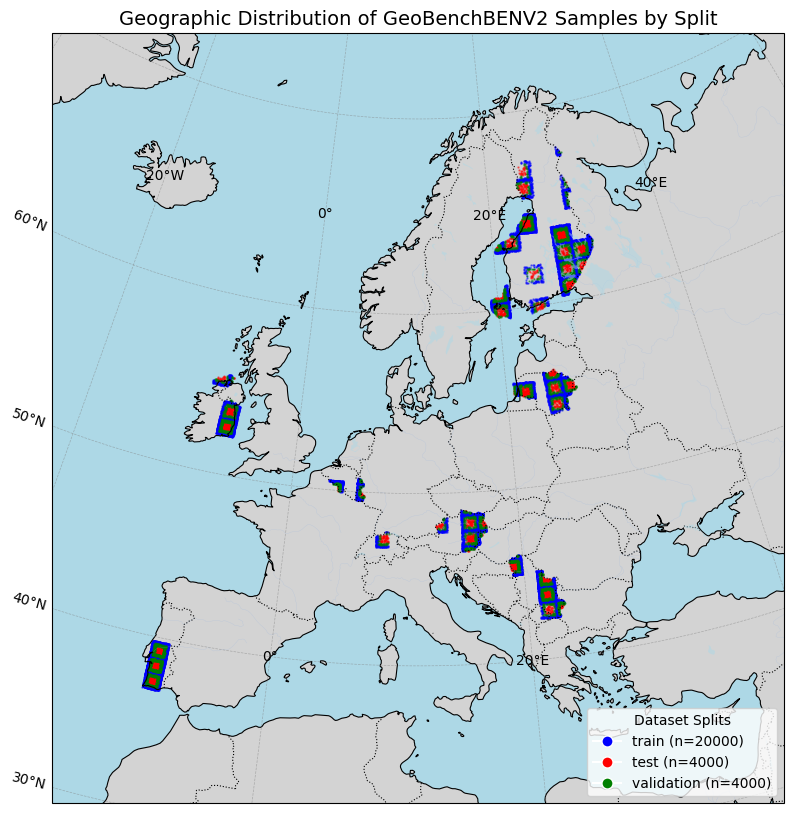

In [14]:
sample_dist_fig = datamodule.visualize_geospatial_distribution()

In [15]:
STATS_DIR = os.path.join(
    PROJECT_ROOT, "geobench_v2", "generate_benchmark", "dataset_stats"
)
STATS_WITH_CLIP_DIR = os.path.join(
    PROJECT_ROOT, "geobench_v2", "generate_benchmark", "dataset_stats_with_clip"
)

# Load dataset statistics from JSON files
direct_stats_path = os.path.join(STATS_DIR, "benv2", "benv2_stats.json")
satmae_stats_path = os.path.join(STATS_WITH_CLIP_DIR, "benv2", "benv2_stats.json")


def create_normalizer_from_stats(stats_path, normalizer_class, band_order):
    """Create a data normalizer from a stats JSON file."""
    with open(stats_path) as f:
        stats = json.load(f)

    means = {}
    stds = {}
    clip_min = {}
    clip_max = {}

    for modality, modality_stats in stats["input_stats"].items():
        mod_name = modality.split("_")[1]
        bands = modality_stats["band_names"]
        mean_values = modality_stats["mean"]
        std_values = modality_stats["std"]

        if "clip_min_used" in modality_stats:
            clip_min[mod_name] = modality_stats["clip_min_used"]
        if "clip_max_used" in modality_stats:
            clip_max[mod_name] = modality_stats["clip_max_used"]

        for i, band in enumerate(bands):
            if i < len(mean_values) and i < len(std_values):
                means[band] = mean_values[i]
                stds[band] = std_values[i]

    norm_stats = {
        "means": means,
        "stds": stds,
        "clip_min": clip_min,
        "clip_max": clip_max,
    }

    # Create normalizer instance
    if normalizer_class == SatMAENormalizer:
        return normalizer_class(norm_stats, band_order, output_range="zero_one")
    else:
        return normalizer_class(norm_stats, band_order)


clip_z_normalizer = create_normalizer_from_stats(
    direct_stats_path, ClipZScoreNormalizer, band_order
)
satmae_normalizer = create_normalizer_from_stats(
    satmae_stats_path, SatMAENormalizer, band_order
)

### Raw Image Statistics

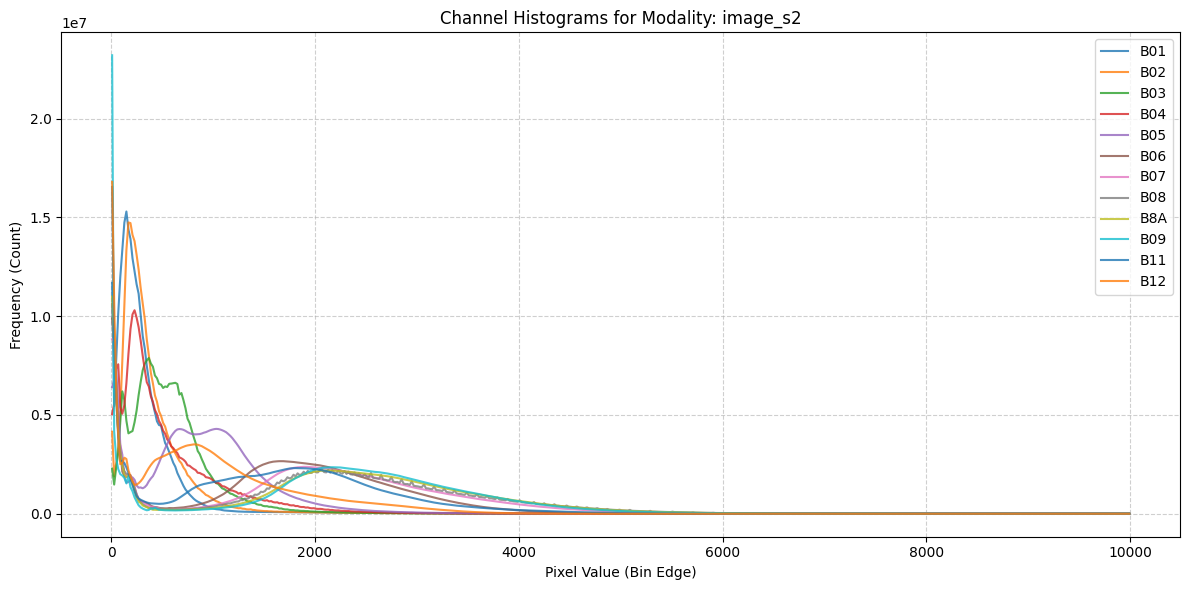

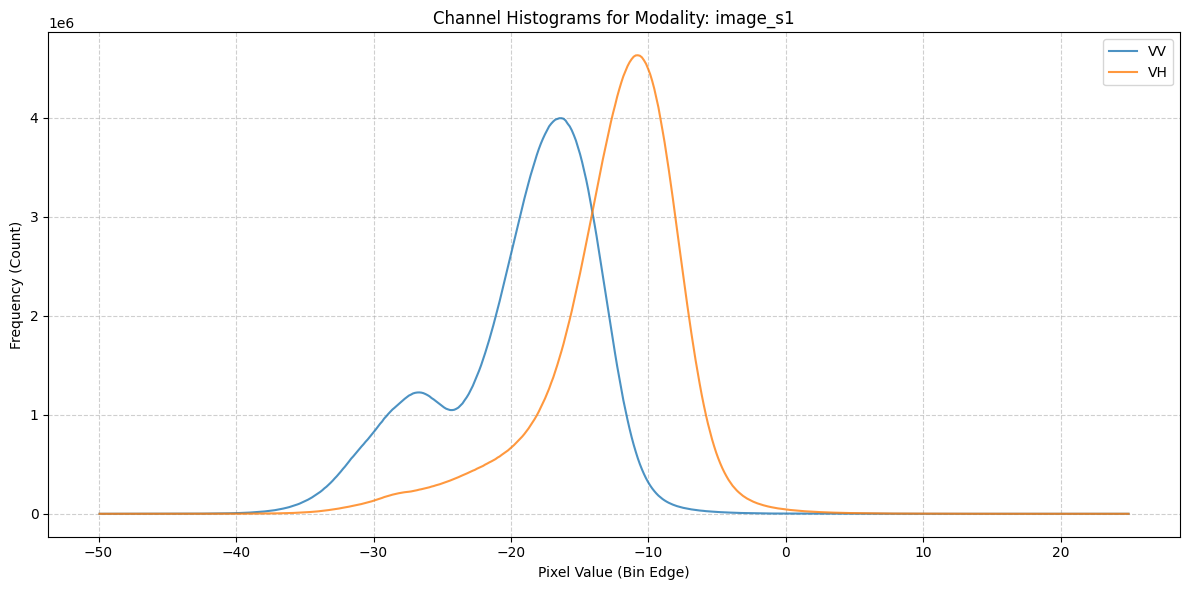

In [16]:
fig = plot_channel_histograms(
    PROJECT_ROOT / "geobench_v2/generate_benchmark/dataset_stats/benv2/benv2_stats.json"
)

### Raw Batch Image Statistics

Statistics of a single batch before any normalization

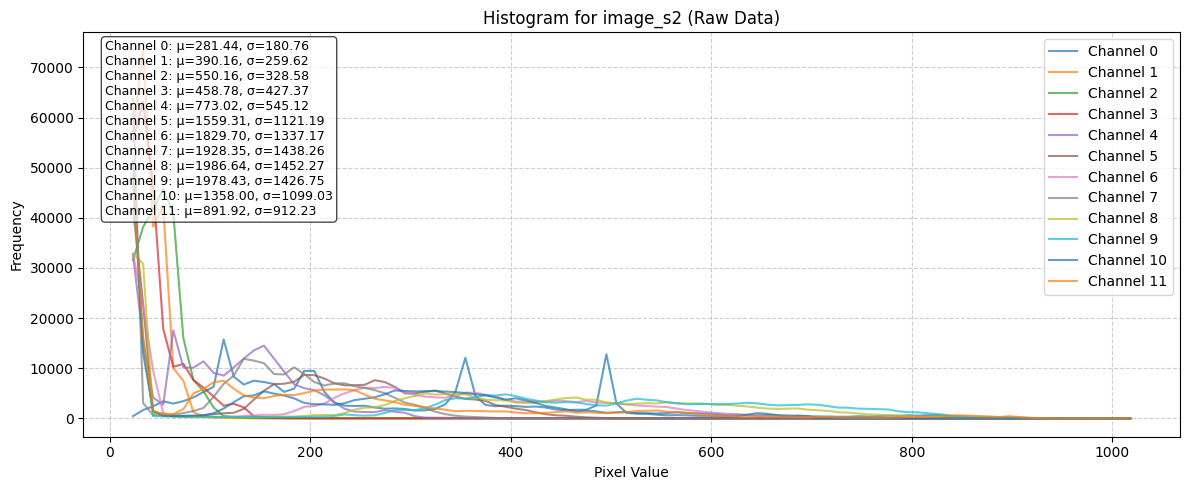

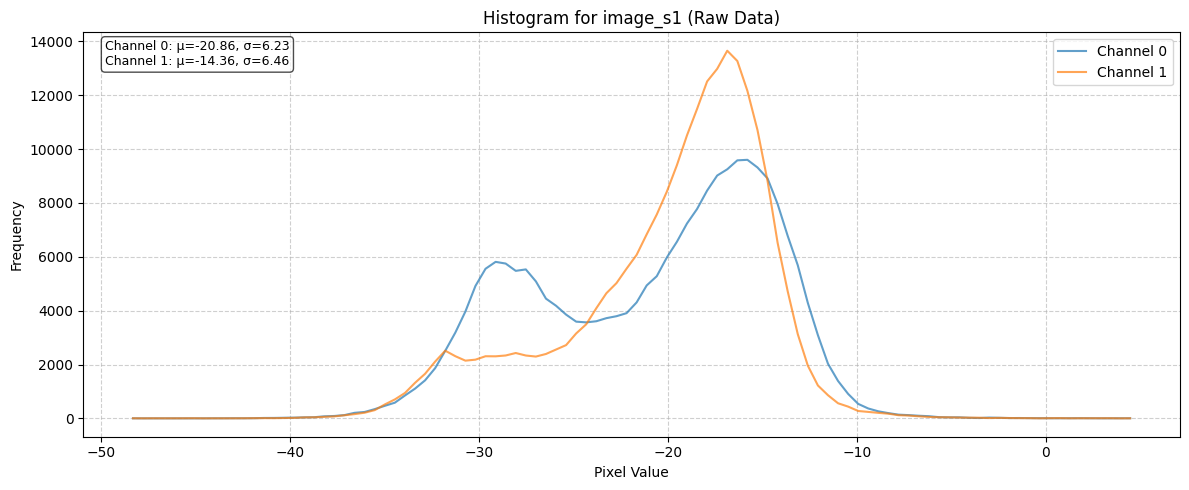

In [17]:
# Get a batch of data from the dataloader
train_dataloader = datamodule.train_dataloader()
raw_batch = next(iter(train_dataloader))

raw_batch_stats = compute_batch_histograms(raw_batch, n_bins=100)

# Plot histograms for raw data
# Create a band_order without scaling factors for visualization
vis_band_order = {
    "s2": [b for b in band_order["s2"] if isinstance(b, str)],
    "s1": [b for b in band_order["s1"] if isinstance(b, str)],
}
raw_figs = plot_batch_histograms(
    raw_batch_stats, vis_band_order, title_suffix=" (Raw Data)"
)

### Effect of SatMAE Normalization scheme on batch

[<Figure size 1200x500 with 1 Axes>, <Figure size 1200x500 with 1 Axes>]

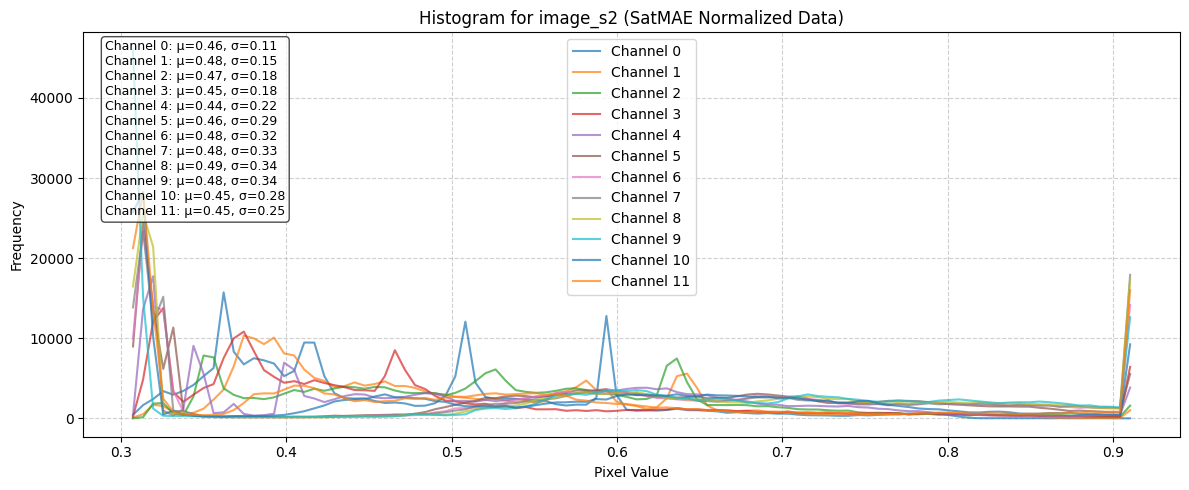

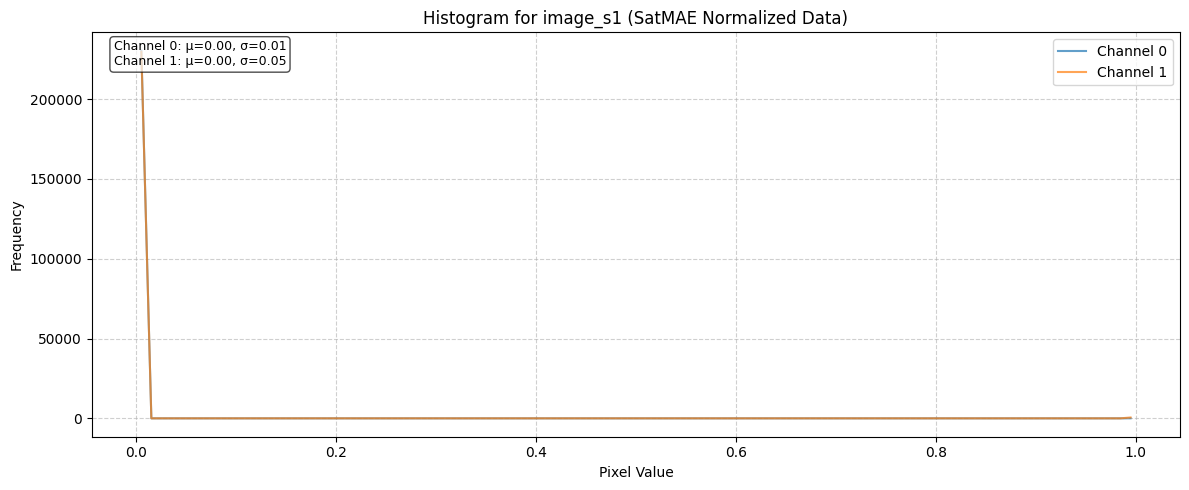

In [18]:
satmae_normalized_batch = satmae_normalizer(raw_batch)
satmae_batch_stats = compute_batch_histograms(satmae_normalized_batch, n_bins=100)
sat_mae_norm_fig = plot_batch_histograms(
    satmae_batch_stats, band_order, title_suffix=" (SatMAE Normalized Data)"
)
sat_mae_norm_fig

### Effect of ClipZ Normalization scheme on batch

[<Figure size 1200x500 with 1 Axes>, <Figure size 1200x500 with 1 Axes>]

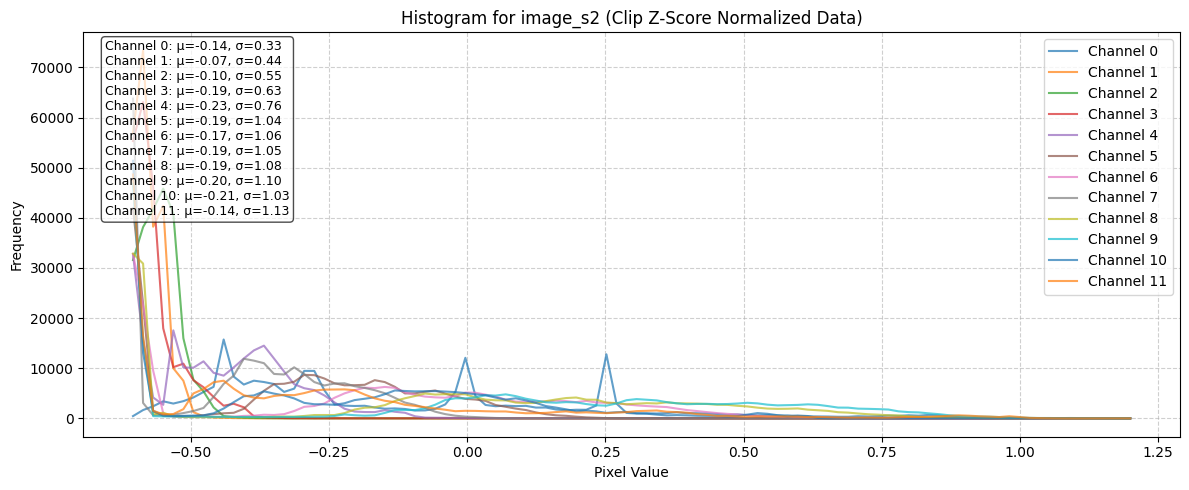

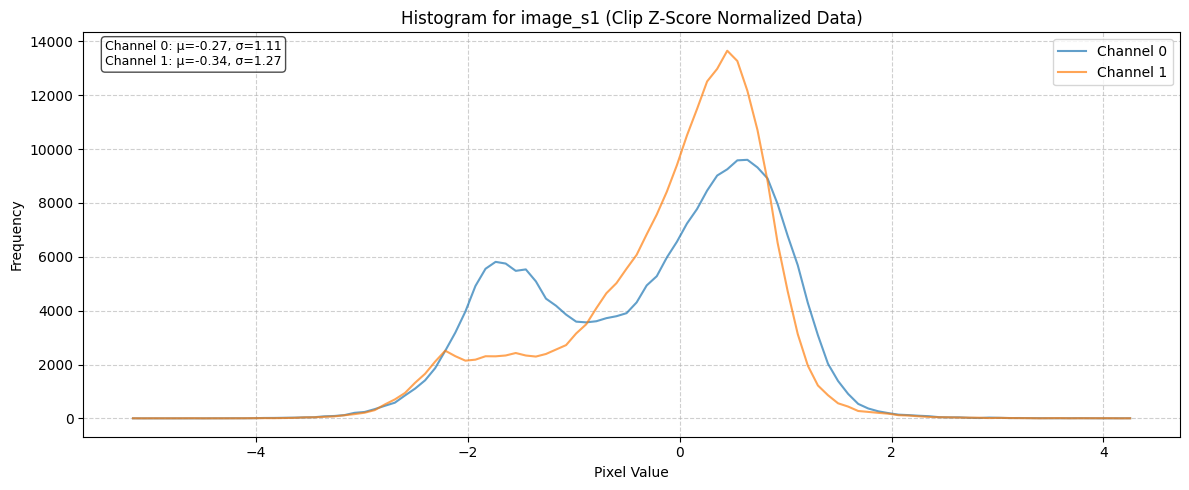

In [19]:
clip_z_normalized_batch = clip_z_normalizer(raw_batch)
clip_z_batch_stats = compute_batch_histograms(clip_z_normalized_batch, n_bins=100)
clip_z_norm_fig = plot_batch_histograms(
    clip_z_batch_stats, band_order, title_suffix=" (Clip Z-Score Normalized Data)"
)
clip_z_norm_fig

## Visualize Batch

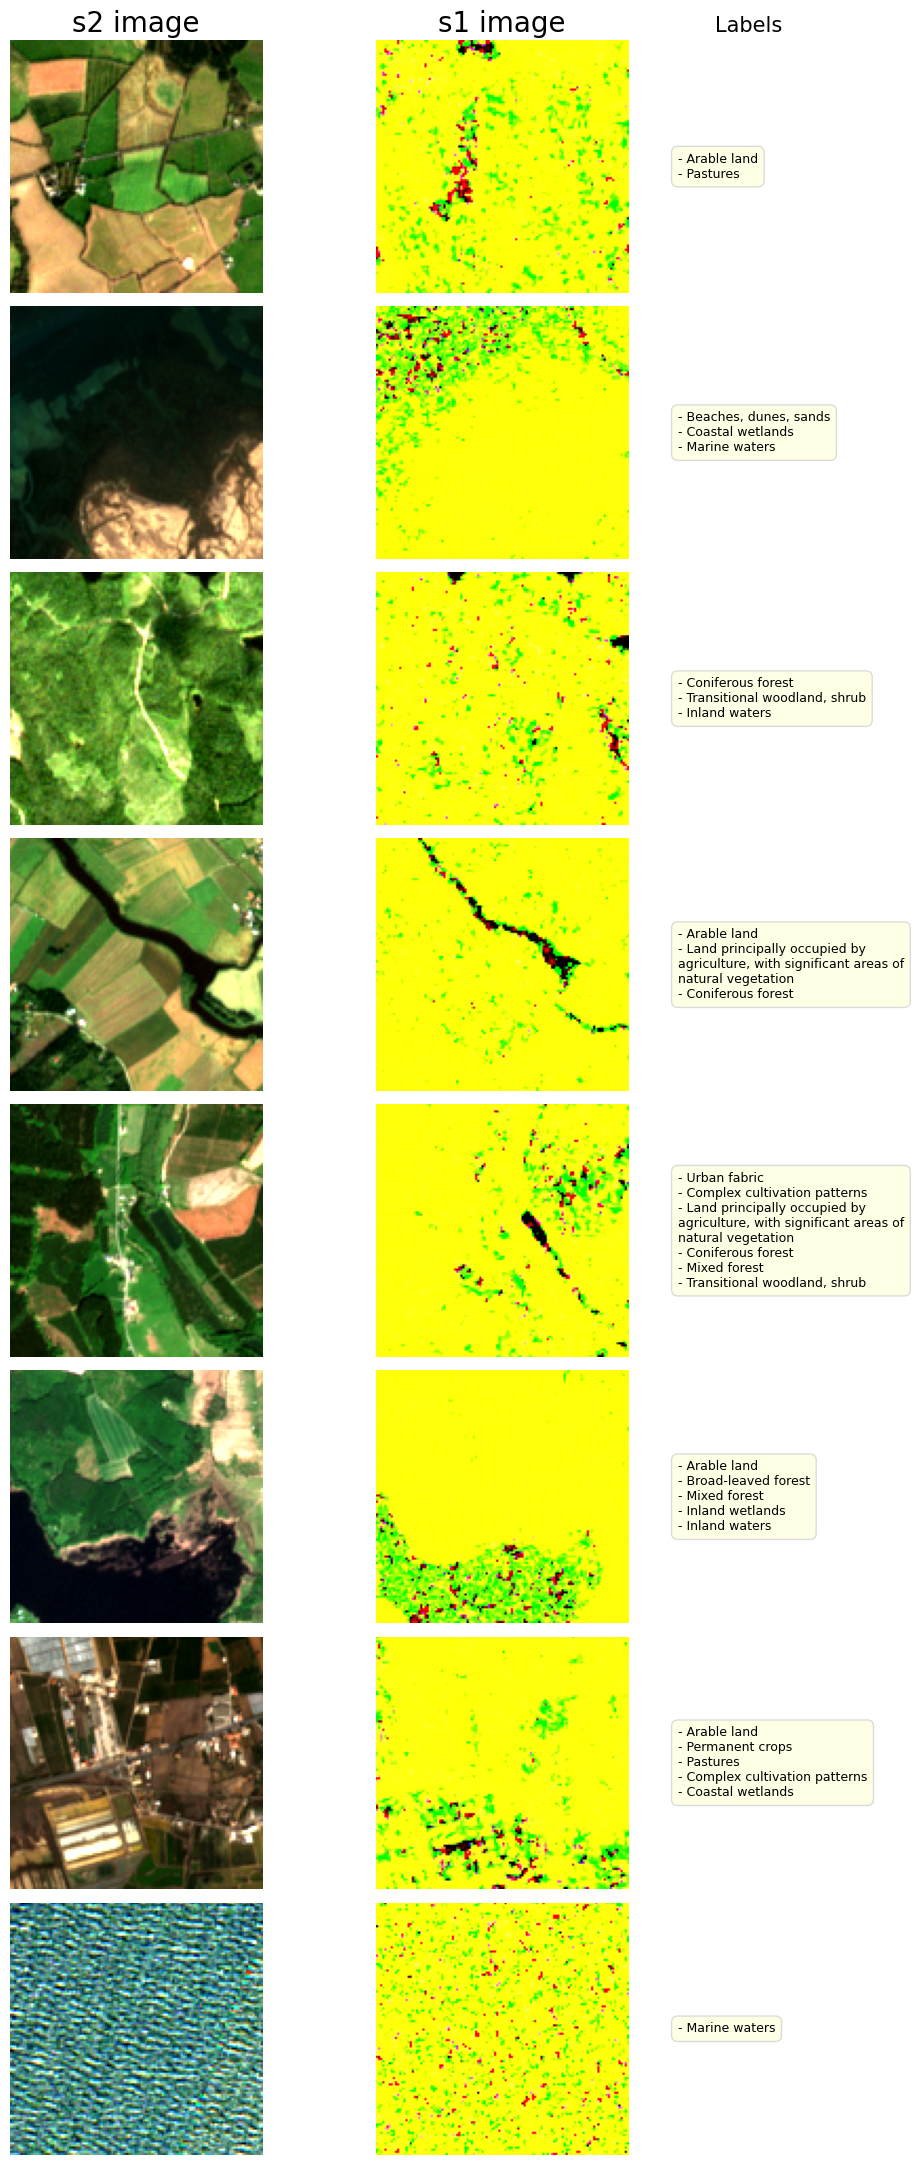

In [20]:
fig, batch = datamodule.visualize_batch()